In [9]:
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
from visualization_helpers import *
from random import sample
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def gaus(x, a, m, s):
    return np.sqrt(a)*np.exp(-(x-m)**2/(2*s**2))

In [17]:
def generate_star_exoplanet(nsample):
    
    xx_s, yy_s = np.meshgrid(np.arange(200), np.arange(200))
    xx_p, yy_p = np.meshgrid(np.arange(10), np.arange(10))

    a_star = np.random.randint(35,40)
    #a_exo = np.random.randint(5,10)

    star_stack = 1.6*(gaus(xx_s, 200, 100, a_star)*gaus(yy_s, 200, 100, a_star))**2
    exo_stack  = 0.78*(gaus(xx_p, 10, 5, 5)*gaus(yy_p, 10, 5, 5))**4
    
    star_stack = np.expand_dims(star_stack,axis=2)
    exo_stack = np.expand_dims(exo_stack,axis=2)
    
    
    for i in tqdm(range(nsample-1)):
        
        xx_s, yy_s = np.meshgrid(np.arange(200), np.arange(200))
        xx_p, yy_p = np.meshgrid(np.arange(10), np.arange(10))

        a_star = np.random.randint(35,40)
        #a_exo = np.random.randint(5,10)

        star_n = 1.6*(gaus(xx_s, 200, 100, 40)*gaus(yy_s, 200, 100, 40))**2
        exo_n = 0.2*(gaus(xx_p, 10, 5, 3)*gaus(yy_p, 10, 5, 3))**5
        
        star_n = np.expand_dims(star_n,axis=2)
        exo_n = np.expand_dims(exo_n,axis=2)
        
        #print(star_stack.shape)
        #print(exo_stack.shape)
        star_stack = np.concatenate((star_stack,star_n),axis=2)
        exo_stack  = np.concatenate((exo_stack,exo_n),axis=2)
        
    return star_stack,exo_stack
    


In [18]:
def generate_datasetSE(nsample):
    
    s,e = generate_star_exoplanet(nsample=nsample)
    
    star_loc = np.random.randint(40,85,nsample)

    x_1 = np.random.randint(125,145,nsample) 
    y_1 = np.random.randint(125,145,nsample) 
    x_2 = np.random.randint(165,170,nsample) 
    y_2 = np.random.randint(165,170,nsample) 
    
    x,y = sample([x_1,y_1,x_2,y_2],2)
    
    raw_skewed = np.maximum(0.0, np.expm1(np.random.normal(4, 1.75, (320,320,nsample)))).astype('uint16')
    
    #raw_skewed[60:260,60:260]  = raw_skewed[60:260,60:260:] + s
    
    for i in tqdm(range(nsample)):
        
        raw_skewed[star_loc[i]:star_loc[i]+200,star_loc[i]:star_loc[i]+200,i:i+1]  = raw_skewed[star_loc[i]:star_loc[i]+200,star_loc[i]:star_loc[i]+200,i:i+1] + s[:,:,i:i+1]
        raw_skewed[y[i]:y[i]+10,x[i]:x[i]+10,i:i+1]  = raw_skewed[y[i]:y[i]+10,x[i]:x[i]+10,i:i+1] + e[:,:,i:i+1]
        
    noise = np.random.normal(20,3,(320,320,nsample)) + np.random.exponential(scale=6,size=(320,320,nsample)) + np.squeeze(np.random.dirichlet(alpha=(10,),size=(320,320,nsample)))
    
    data = raw_skewed + 3*noise
    
    return data

In [41]:
def generate_star(nsample):
    
    xx_s, yy_s = np.meshgrid(np.arange(200), np.arange(200))
    xx_p, yy_p = np.meshgrid(np.arange(10), np.arange(10))
    a_star = np.random.randint(35,40)
    star_stack = 1.6*(gaus(xx_s, 200, 100, a_star)*gaus(yy_s, 200, 100, a_star))**2
    star_stack = np.expand_dims(star_stack,axis=2)
    
    for i in tqdm(range(nsample-1)):
        
        xx_s, yy_s = np.meshgrid(np.arange(200), np.arange(200))
        xx_p, yy_p = np.meshgrid(np.arange(10), np.arange(10))

        a_star = np.random.randint(35,40)

        star_n = 1.6*(gaus(xx_s, 200, 100, 40)*gaus(yy_s, 200, 100, 40))**2
        
        star_n = np.expand_dims(star_n,axis=2)
        
        star_stack = np.concatenate((star_stack,star_n),axis=2)
        
    return star_stack

In [42]:
def generate_datasetS(nsample):
    
    s = generate_star(nsample=nsample)
    star_loc = np.random.randint(40,95,nsample)
    raw_skewed = np.maximum(0.0, np.expm1(np.random.normal(4, 1.75, (320,320,nsample)))).astype('uint16')
    
    for i in tqdm(range(nsample)):
        raw_skewed[star_loc[i]:star_loc[i]+200,star_loc[i]:star_loc[i]+200,i:i+1]  = raw_skewed[star_loc[i]:star_loc[i]+200,star_loc[i]:star_loc[i]+200,i:i+1] + s[:,:,i:i+1]
        
    noise = np.random.normal(20,3,(320,320,nsample)) + np.random.exponential(scale=6,size=(320,320,nsample)) + np.squeeze(np.random.dirichlet(alpha=(10,),size=(320,320,nsample)))
    data = raw_skewed + 3*noise
    
    return data

In [14]:
def visualize_syn_data(data):
    _, axes = plt.subplots(nrows=5,ncols=5,figsize=(20,20))

    for i, (row,col) in enumerate(product(range(5),range(5))):
        
        axes[row][col].imshow(data[:,:,i],cmap='gray')
        axes[row][col].set_yticks([])
        axes[row][col].set_xticks([])
        
    _.patch.set_facecolor('#423f3b')
    plt.subplots_adjust(wspace=0,hspace=0)
    plt.show()  

In [16]:
se_data1 = generate_datasetSE(nsample=1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:54<00:00, 18.25it/s]


In [25]:
se_data1 = np.concatenate((se_data1,se_data2),axis=2)

In [27]:

for i in tqdm(range(8)):
    
    data = generate_datasetSE(nsample=1000)
    
    se_data1 = np.concatenate((se_data1,data),axis=2)
    

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:56<00:00, 17.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:54<00:00, 18.32it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:55<00:00, 18.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:55<00:00, 18.14it/s]

100%|███████

In [28]:
se_data1.shape

(320, 320, 10000)

In [44]:
s_data = generate_datasetS(nsample=1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1746.99it/s]


In [ ]:
for i in tqdm(range(9)):
    
    data = generate_datasetS(nsample=1000)
    
    s_data = np.concatenate((s_data,data),axis=2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:53<00:00, 18.56it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:54<00:00, 18.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:54<00:00, 18.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:54<00:00, 18.47it/s]

100%|███████

In [ ]:
s_data

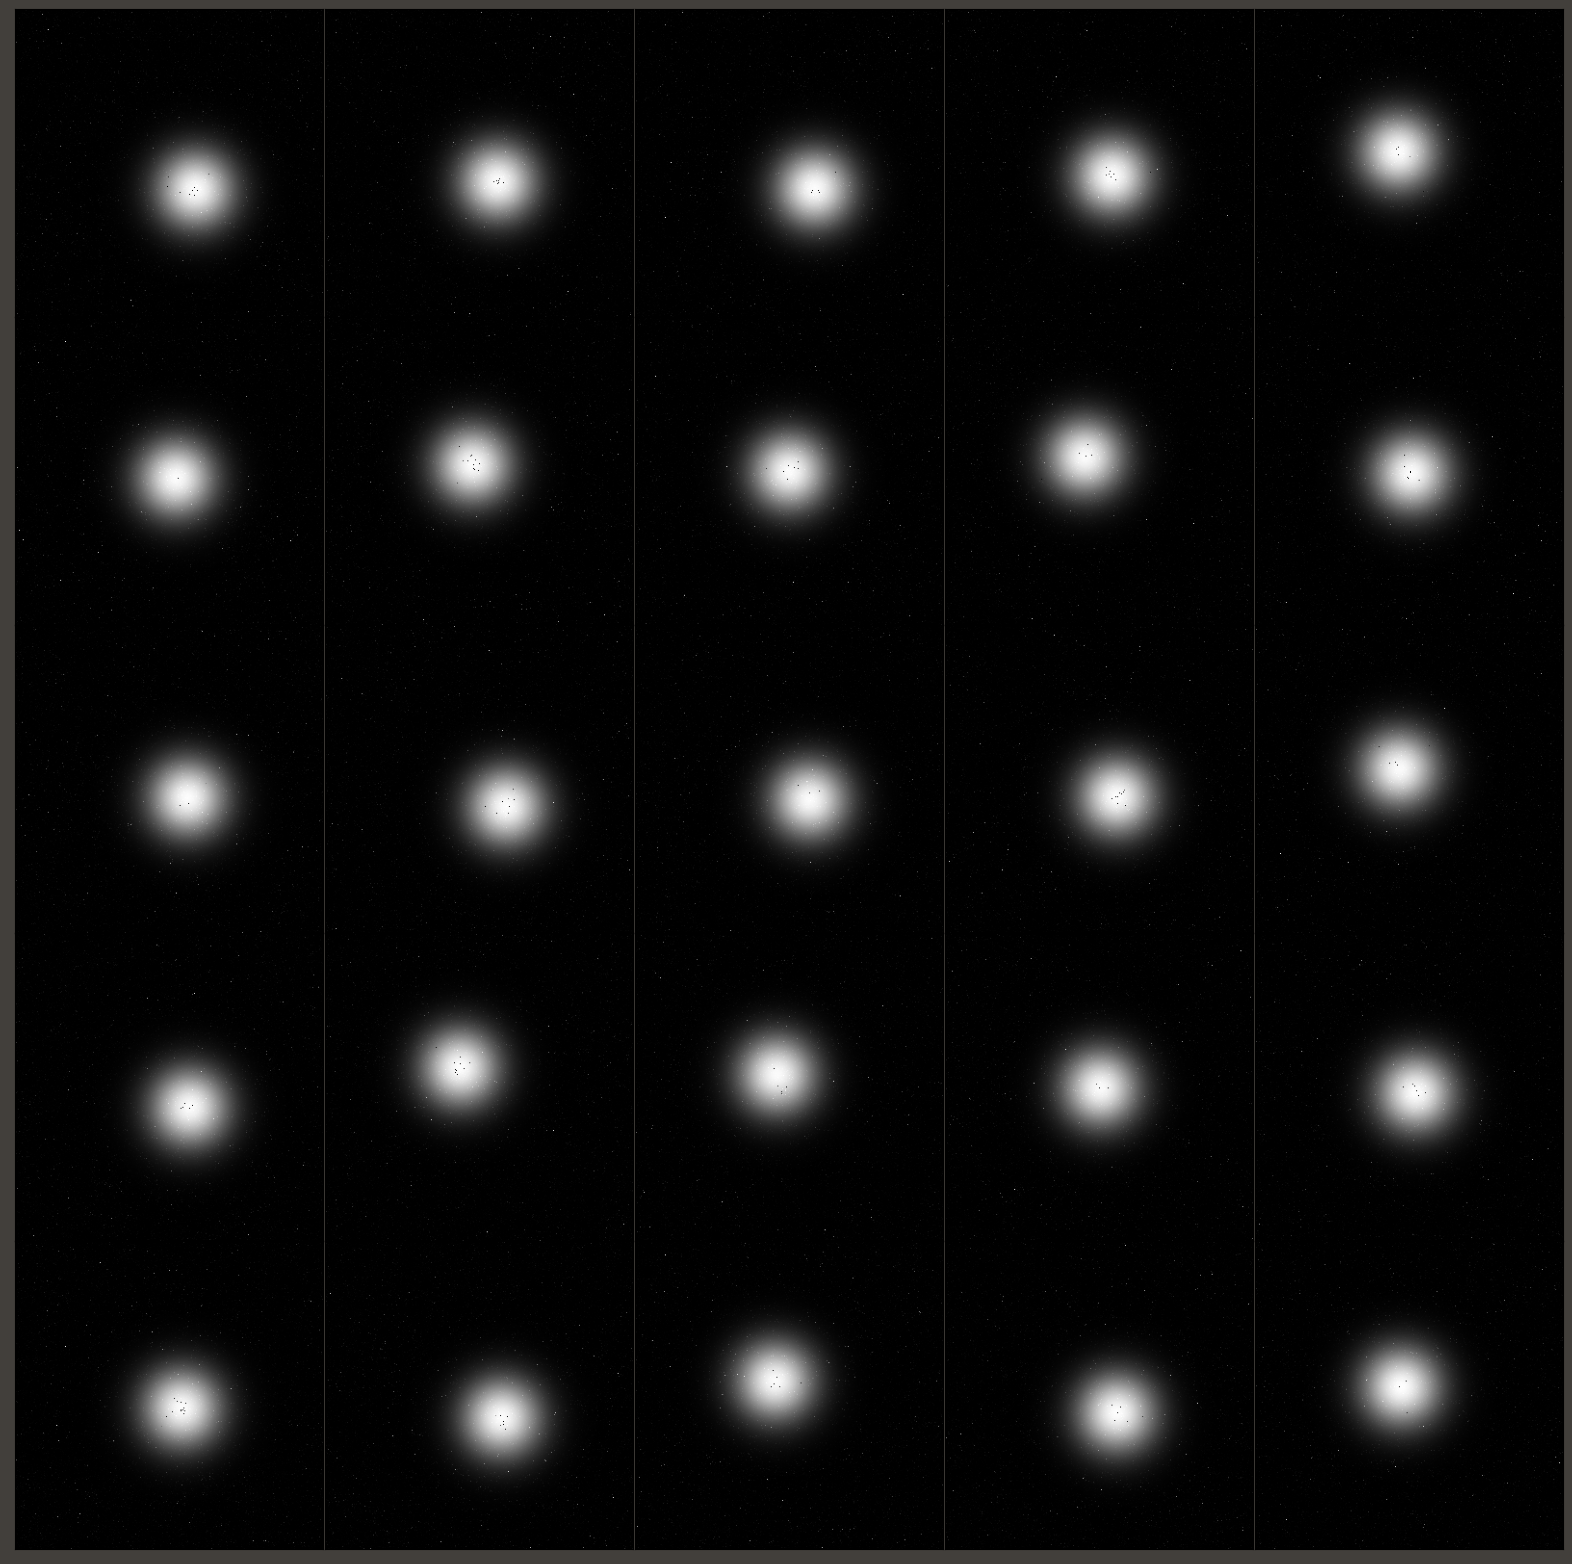

In [47]:
visualize_syn_data(s_data[:,:,600:700])

In [23]:
s_data = generate_datasetS(nsample=20000)

In [9]:
se_ = np.load('se_1000.npy')

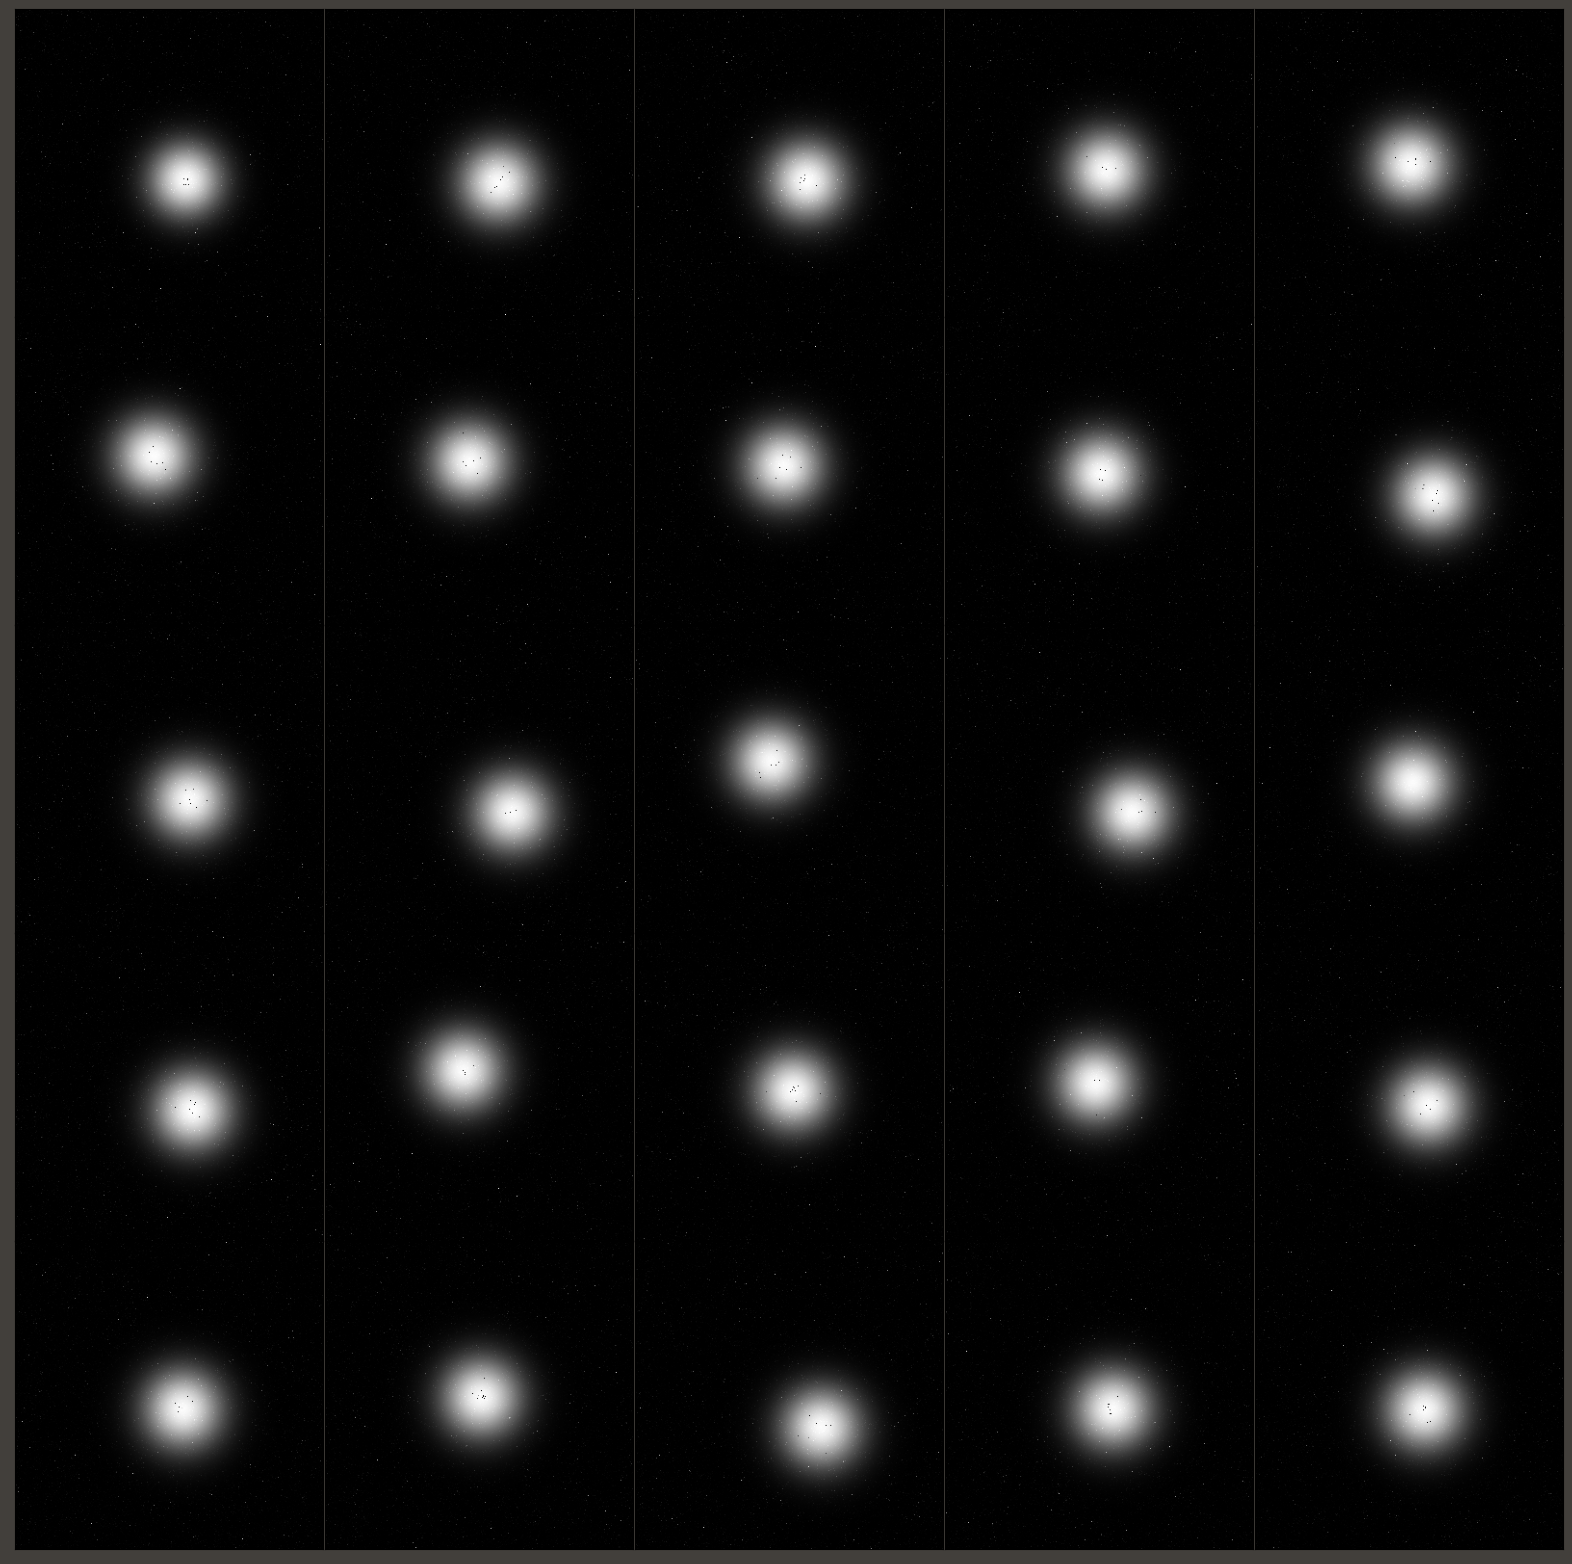

In [24]:
visualize_syn_data(s_data)